# Lab 2 - Time series analysis

A `julia` version of lab 2 MATH5271. 
We look at frequency domain analysis of time series and cover:

- Fit specific harmonics (sine and cosine functions) to data using least squares and integration methods,
- Use Fast Fourier Transform (FFT) functions and interpret their results and
- Use ideas related to the Nyquvist frequency to understand aliased signals.

What we are working towards is calculation of coefficents for the harmonics.
This can be done using least squares or Fourier coefficents, both methods are demonstrated below. 

## Setup and load data

Looking at `Wilks_Table8.6.csv` data for this lab.
Packages needed for this lab are

In [4]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [40]:
using DataFrames, CSV, Plots, Statistics, LinearAlgebra

In [23]:
df = DataFrame(CSV.File("Wilks_Table8.6.csv"))
df

,Month,Year,Temp_Far,Location
,Int64,Int64,Float64,String7
1,1,1987,21.4,Ithaca
2,2,1987,17.9,Ithaca
3,3,1987,35.9,Ithaca
4,4,1987,47.7,Ithaca
5,5,1987,56.4,Ithaca
6,6,1987,66.3,Ithaca
7,7,1987,70.9,Ithaca
8,8,1987,65.8,Ithaca
9,9,1987,60.1,Ithaca


## Fitting harmonics

As discussed in Wilks, there are a few ways of fitting a harmonic to a data set. Let's first define a harmonic with a sin and a cosine curve

$$ A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right) $$

where $k$ is the order of the harmonic (between 1 and $n$/2) and $n$ is the number of data points in the time series (assuming constant spaceing of data).

Clearly the temperature data is likely to have an annual cycle and since we have 2 years this means $k = 2$. Let's define the cosine and sine functions for $k=2$ and plot them.

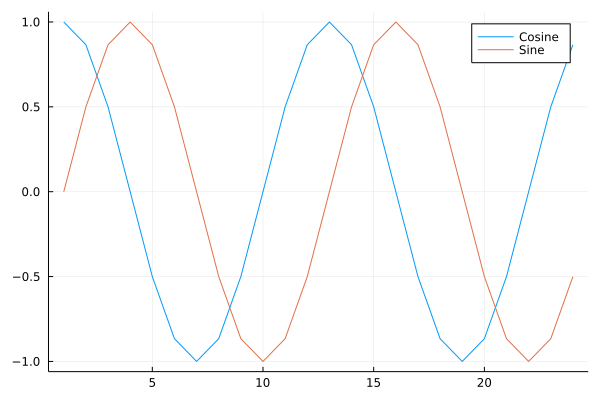

In [51]:
k = 2
n = length(df[:, :Temp_Far])
i = 0:n-1 # 24 months is where this came from
cosfun = @. cos((2 * π * i * k) / n)
sinfun = @. sin((2 * π * i * k) / n)
plot(cosfun, label = "Cosine")
plot!(sinfun, label = "Sine")

## Least Squares
If we want to fit just a single harmonic, then an obvious approach is 'Least Squares' where find $A_k$ and $B_k$ such 

$$ y_i - \overline{y} = A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right) + \epsilon_i $$

and the root mean square of the error term ($\sum \epsilon_i^2$) is minimised. 

In order to exploit powerful linear algebra methods we can cast the above problem into matrix form such that 

$$ A \bf{x} = \bf{y} - \bf{E} $$

Where $A$ is a 2 x $n$ matrix containing the cosine and sine functions, $\bf{x} = [A_k,B_k]$. Let's try this and minimise the error using numpy's linear algerbar - least squares function.

[-23.739767027193718, -2.1638511734738546]


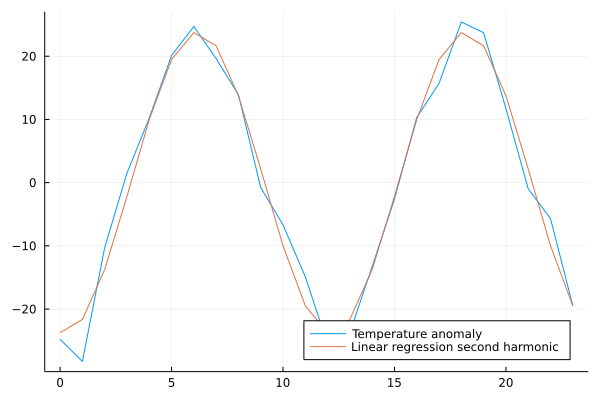

In [84]:
A = [cosfun sinfun]
y = df[:, :Temp_Far] .- mean(df[:, :Temp_Far])
x = A \ y
println(x)
y_2nd_harmonic_reg = @. x[1] * cosfun + x[2] * sinfun
#println(y_2nd_harmonic_reg)
plot(i, y, label = "Temperature anomaly", legend = :bottomright)
plot!(i, y_2nd_harmonic_reg, label = "Linear regression second harmonic")

### Summation formula

Least squares is actually not necassary in this case. We can actually compute a coefficient using the summation formulae

$$ A_k = \frac{2}{n}\sum_{i=1}^{n}y_n\cos\left(\frac{2\pi i k}{n}\right)$$

and
$$ B_k = \frac{2}{n}\sum_{i=1}^{n}y_n\sin\left(\frac{2\pi i k}{n}\right).$$

Let's try this.

In [64]:
A2 = (2/ n) * sum(y .* cosfun)
println(A2)
B2 = (2/ n) * sum(y .* sinfun)
println(B2)
isapprox([A2, B2], x)

-23.739767027193714
-2.1638511734738555


true

Which is the same as far as `julia` is concerned!
So we have the linear regression method as well as the Fourier coefficient method.
We can turn this into a function that can be used for all such situations, then check if it gives same results.

In [76]:
function fourtrans(y, k)
    n = length(y)
    i = 0:(n - 1)
    Aₖ = (2 / n) * sum(y .* cos.((2 * π * i * k) / n))
    Bₖ = (2 / n) * sum(y .* sin.((2 * π * i * k) / n))
    return [Aₖ, Bₖ]
end

fourtrans (generic function with 1 method)

In [77]:
test_fun = fourtrans(y, k)

2-element Vector{Float64}:
 -23.739767027193714
  -2.1638511734738577

More common is to use fast Fourier transforms of which `julia` has a very nice one.

## Exercise

----

Get into groups of 3-4 and complete the following:

1.   Explore ways of removing the sesonal cycle from the Ithaca temperature data using the methods above. What is the general way to construct a time series with/without certain modes of variability.

2.   Add in higher frequency modes of variability to the Ithaca times series. Show how these can be picked up bu the FFT and also iullustrate how they may not. Discuss in relation to the Nyquvist frequency.

3.   Looking why Wilks' values are different.


----

### 1.
Temperature anomaly - second harmonic, does this remove seasonal trend?
It looks to as we now have something showing trends about zero rather than the full periodic fluctuations.

Look to the textbook as I think there is clear example on how this is done.

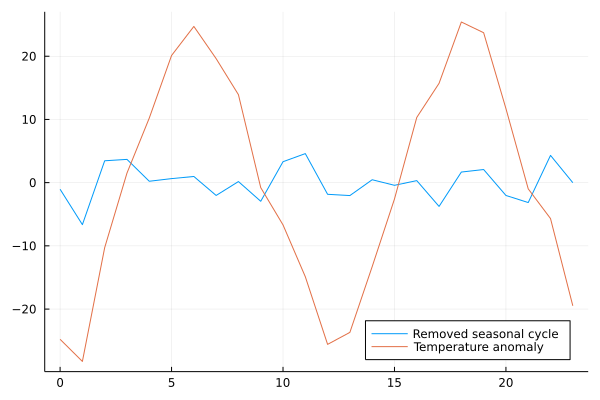

In [86]:
no_seasonal_cycle = y .- y_2nd_harmonic_reg
plot(i, no_seasonal_cycle, label = "Removed seasonal cycle", legend = :bottomright)
plot!(i, y, label = "Temperature anomaly")

Can express $y$ using
$$
y_{i} - \bar{y} = \sum_{k=1}^{n/2}A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right).
$$
so we can remove a **specific harmonic** by
$$
y_{i}^{filtered} = \sum_{k\neq }^{n/2}A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right) + \bar{y}
$$
which is the general way to remove a desired harmonic $l$.

The way is done above is
$$
y_{i} - \bar{y} - A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right),
$$
for $k = 2$ - that is, we remove the second harmonic.